# Texts multi-label classification using Keras & FastText
---

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
import fasttext

from tqdm.notebook import tqdm
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Flatten, Dropout, Reshape
import keras.backend as K

Using TensorFlow backend.
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jakub/Dokumenty/venv36/lib/pytho

In [2]:
print('Tensorflow:', tf.__version__)

Tensorflow: 2.0.0-beta1


In [3]:
pd.set_option('display.max_colwidth', 400)

## Data loading
---

In [4]:
movies_df = pd.read_csv('ml_class_text2/tmdb-movie-metadata/tmdb_5000_movies.csv')
movies_df = movies_df[['id', 'title', 'overview', 'tagline', 'genres']]
movies_df = movies_df.fillna('no text')
movies_df['genres'] = movies_df['genres'].replace('[]', '[{"id": 00, "name": "NoGenre"}]')
movies_df.head()

,id,title,overview,tagline,genres
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",Enter the World of Pandora.,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]"
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.","At the end of the world, the adventure begins.","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]"
2,206647,Spectre,"A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.",A Plan No One Escapes,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]"
3,49026,The Dark Knight Rises,"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a cit...",The Legend Ends,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name"": ""Thriller""}]"
4,49529,John Carter,"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands.","Lost in our world, found in another.","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 878, ""name"": ""Science Fiction""}]"


In [5]:
print(f'Movies dataframe: {movies_df.shape}')

Movies dataframe: (4803, 5)


In [6]:
movies_df['text'] = movies_df['title'] + ' | ' + movies_df['tagline'] + ' | ' + movies_df['overview']
movies_df = movies_df.drop(['title', 'overview', 'tagline'], axis=1)
movies_df.head()

,id,genres,text
0,19995,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]","Avatar | Enter the World of Pandora. | In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization."
1,285,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]","Pirates of the Caribbean: At World's End | At the end of the world, the adventure begins. | Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems."
2,206647,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]","Spectre | A Plan No One Escapes | A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE."
3,49026,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 53, ""name"": ""Thriller""}]","The Dark Knight Rises | The Legend Ends | Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. T..."
4,49529,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 878, ""name"": ""Science Fiction""}]","John Carter | Lost in our world, found in another. | John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands."


## Preprocessing
---

In [7]:
ft_model = fasttext.load_model('ml_class_text2/cc.en.300.bin')

In [8]:
texts = movies_df['text'].values
X = np.array([ft_model[t] for t in texts])
#X = X.reshape(-1, 100, 3)

In [9]:
del ft_model

In [10]:
X.shape

(4803, 300)

In [11]:
genres = movies_df['genres'].values
genres_sets = [set([gg.split(':')[-1][2:-1] for gg in g[2:-2].split('},')]) for g in genres]

In [12]:
genres_sets[:5]

[{'Action', 'Adventure', 'Fantasy', 'Science Fiction'},
 {'Action', 'Adventure', 'Fantasy'},
 {'Action', 'Adventure', 'Crime'},
 {'Action', 'Crime', 'Drama', 'Thriller'},
 {'Action', 'Adventure', 'Science Fiction'}]

In [13]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genres_sets)
#y = y.reshape(-1, 1, np.size(mlb.classes_))

In [14]:
n_classes = np.size(mlb.classes_)
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'NoGenre', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype=object)

In [15]:
y.shape

(4803, 21)

## Classs weighting
---
Dealing with imbalanced classes.

In [16]:
counts = np.array(np.sum(y, axis=0)).flatten()
counts

array([1154,  790,  234, 1722,  696,  110, 2297,  513,  424,   34,  197,
        519,  185,  348,   28,  894,  535,    8, 1274,  144,   82])

In [17]:
weights = np.array([np.size(counts)/np.float32(c) for c in counts])
weights

array([0.01819757, 0.02658228, 0.08974359, 0.01219512, 0.03017241,
       0.19090909, 0.00914236, 0.04093567, 0.0495283 , 0.61764706,
       0.10659898, 0.04046243, 0.11351351, 0.06034483, 0.75      ,
       0.02348993, 0.03925234, 2.625     , 0.01648352, 0.14583333,
       0.25609756])

In [18]:
class_weight = dict({i: w for i, w in enumerate(weights)})

## Model
---

In [19]:
TRAIN_RATIO, TEST_RATIO = 0.6, 0.7

In [20]:
X_train, X_val, X_test = X[:int(len(X)*TRAIN_RATIO)], X[int(len(X)*TRAIN_RATIO):int(len(X)*TEST_RATIO)], X[int(len(X)*TEST_RATIO):]
y_train, y_val, y_test = y[:int(len(y)*TRAIN_RATIO)], y[int(len(y)*TRAIN_RATIO):int(len(y)*TEST_RATIO)], y[int(len(y)*TEST_RATIO):]

print(f'X_train: {X_train.shape} | y_train: {y_train.shape}')
print(f'X_val: {X_val.shape} | y_val: {y_val.shape}')
print(f'X_test: {X_test.shape} | y_test: {y_test.shape}')

X_train: (2881, 300) | y_train: (2881, 21)
X_val: (481, 300) | y_val: (481, 21)
X_test: (1441, 300) | y_test: (1441, 21)


In [21]:
INIT = 'random_uniform'
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 10

In [22]:
inputs = Input(shape=(300,), name='embeddings')
h = Reshape((100, 3), name='input_reshaper')(inputs)
h = Conv1D(100, 2, activation='relu', name='conv1d_0', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = MaxPool1D(pool_size=3, name='pool1d_0')(h)
h = Conv1D(100, 2, activation='relu', name='conv1d_1', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = MaxPool1D(pool_size=2, name='pool1d_1')(h)
h = Dropout(0.1, name='dropout_0')(h)
h = Flatten(name='flattener')(h)
h = Dense(500, activation='relu', name='dense_0', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dense(300, activation='relu', name='dense_1', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dense(100, activation='relu', name='dense_2', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dropout(0.1, name='dropout_1')(h)
outputs = Dense(21, activation='sigmoid', name='predictions', kernel_initializer=INIT, bias_initializer=INIT)(h)

NN = Model(inputs=inputs, outputs=outputs, name='texts_multilabel_classifier')

In [23]:
NN.summary()

Model: "texts_multilabel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (InputLayer)      [(None, 300)]             0         
_________________________________________________________________
input_reshaper (Reshape)     (None, 100, 3)            0         
_________________________________________________________________
conv1d_0 (Conv1D)            (None, 99, 100)           700       
_________________________________________________________________
pool1d_0 (MaxPooling1D)      (None, 33, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 100)           20100     
_________________________________________________________________
pool1d_1 (MaxPooling1D)      (None, 16, 100)           0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 16,

In [24]:
class JaccardDistance(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        """ Calculates mean of Jaccard similarity as a metric function """
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
        jac = (intersection) / (sum_ - intersection)
        return tf.reduce_mean(1 - jac)

class MeanSquaredError(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return tf.reduce_mean(K.square(y_pred - y_true), axis=-1)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

def jaccard_similarity(y_true, y_pred):
    """ Calculates mean of Jaccard similarity as a metric function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    sum_ = tf.reduce_sum(y_true + y_pred, axis=-1)
    jac = (intersection) / (sum_ - intersection)
    return tf.reduce_mean(jac)

NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
           loss=tf.keras.losses.BinaryCrossentropy(),
           metrics=[tf.keras.metrics.BinaryAccuracy(), jaccard_similarity])

In [25]:
tqdm_callback = TQDMNotebookCallback()
fit_results = NN.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, class_weight=class_weight,
                     validation_data=(X_val, y_val), verbose=0, callbacks=[tqdm_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
predictions = NN.predict(X_test)

In [27]:
fit_results.history

{'loss': [0.010783814729108283,
  0.007189845369694931,
  0.007150410980481431,
  0.0071220709504259,
  0.007133246997661606,
  0.007105401616591374,
  0.007112114004844444,
  0.007095120650195995,
  0.007090434597944792,
  0.007099509447055304],
 'binary_accuracy': [0.7734252,
  0.86882854,
  0.86899376,
  0.8688782,
  0.86889464,
  0.8689113,
  0.86892784,
  0.8689279,
  0.8689278,
  0.8689278],
 'jaccard_similarity': [0.11202672,
  0.12566449,
  0.12780719,
  0.12709081,
  0.12656192,
  0.124641754,
  0.12615907,
  0.12656814,
  0.12459276,
  0.12594877],
 'val_loss': [0.3079692073274799,
  0.3016784297701227,
  0.30768606909347423,
  0.3112379805709617,
  0.30608673942064296,
  0.3144057776600804,
  0.3062179736065022,
  0.3064587417982224,
  0.3090807663551735,
  0.3073132108749818],
 'val_binary_accuracy': [0.88446695,
  0.88446695,
  0.8844669,
  0.88446695,
  0.8844669,
  0.8844669,
  0.8844669,
  0.8844669,
  0.88446695,
  0.88446695],
 'val_jaccard_similarity': [0.13101013,
 

In [28]:
def training_progress_plot(results, title, save_file=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.array(results.epoch)+1)
    
    ax1.set_ylabel('Binary accuracy', color='r')
    ax1.plot(np.array(results.epoch)+1, results.history['binary_accuracy'], 'r-', label='accuracy')
    ax1.plot(np.array(results.epoch)+1, results.history['val_binary_accuracy'], 'r--', label='val. accuracy')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='center')
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Binary loss', color='b')
    ax2.plot(np.array(results.epoch)+1, results.history['loss'], 'b-', label='loss')
    ax2.plot(np.array(results.epoch)+1, results.history['val_loss'], 'b--', label='val. loss')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='center right')
    
    fig.tight_layout()
    plt.title(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

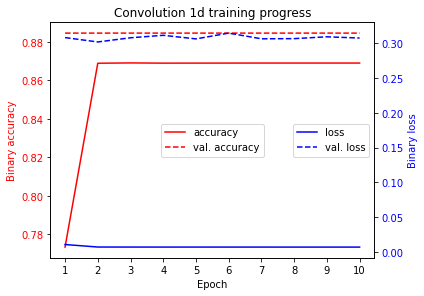

In [29]:
training_progress_plot(fit_results, title='Convolution 1d training progress',
                       save_file='ml_class_text2/training_progress.png')

## Predictions
---

In [30]:
# find best accuracy values in given prediction threshold values
pred_thrs = np.arange(0.09, 0.4, 0.0001)
pred_thrs

array([0.09  , 0.0901, 0.0902, ..., 0.3998, 0.3999, 0.4   ])

In [31]:
# accuracy measure for flattened zero-one arrays
def binary_flatten_accuracy(y_true, y_pred):
    cm = tf.math.confusion_matrix(y_true.flatten(), y_pred.flatten()).numpy()
    return float(np.sum(np.diag(cm)))/np.sum(np.sum(cm))

# accuracy measure for labeled (different length) arrays
def exact_match_ratio(y_true, y_pred):
    matches = 0.
    for y_t, y_p in zip(y_true, y_pred):
        if np.array_equal(sorted(y_t), sorted(y_p)):
            matches += 1.
    return matches/y_true.shape[0]

# accuracy measure for labeled (different length) arrays
def multilabel_accuracy(y_true, y_pred):
    score = 0.
    for y_t, y_p in zip(y_true, y_pred):
        score += np.float32(np.size(np.intersect1d(y_t, y_p)))/np.size(np.union1d(y_t, y_p))
    
    return score/y_true.shape[0]

In [32]:
def accuracy_depencies(labels, logits, thr_s, save_file=None):
    dependencies = list([])
    for thr in tqdm(thr_s):
        y_true = np.array(labels)
        y_pred = np.array([np.vectorize(lambda p: 1 if p>thr else 0)(l) for l in logits])
        
        num_y_true = np.array([np.where(l==1)[0] for l in y_true])
        num_y_pred = np.array([np.where(l==1)[0] for l in y_pred])
        
        bf_acc = binary_flatten_accuracy(y_true, y_pred)
        emr = exact_match_ratio(num_y_true, num_y_pred)
        ml_acc = multilabel_accuracy(num_y_true, num_y_pred)
        
        dependencies.append([thr, bf_acc, emr, ml_acc])
    
    # build dataframe
    df = pd.DataFrame(dependencies,
                      columns=['threshold', 'flat. acc.', 'em. ratio', 'ml. acc.'])
    df = df.set_index('threshold')
    
    if save_file:
        df.to_csv(save_file)
    return df

In [33]:
acc_dep = accuracy_depencies(labels=y_test, logits=predictions, thr_s=pred_thrs,
                             save_file='ml_class_text2/accuracy_depencies.csv')
acc_dep

,flat. acc.,em. ratio,ml. acc.
threshold,,,
0.0900,0.462410,0.0,0.147092
0.0901,0.462410,0.0,0.147092
0.0902,0.462410,0.0,0.147092
0.0903,0.462410,0.0,0.147092
0.0904,0.462410,0.0,0.147092
...,...,...,...
0.3996,0.897855,0.0,0.000000
0.3997,0.897855,0.0,0.000000
0.3998,0.897855,0.0,0.000000


In [34]:
def accuracy_dependecies_plot(df, title, save_file=None):
    plt.figure(figsize=(16, 4))
    
    x_space = df.index.values
    plt.plot(x_space, df['flat. acc.'].values, label='flattened accuracy')
    plt.plot(x_space, df['em. ratio'].values, label='exact match ratio')
    plt.plot(x_space, df['ml. acc.'].values, label='multilabel accuracy')
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction threshold')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

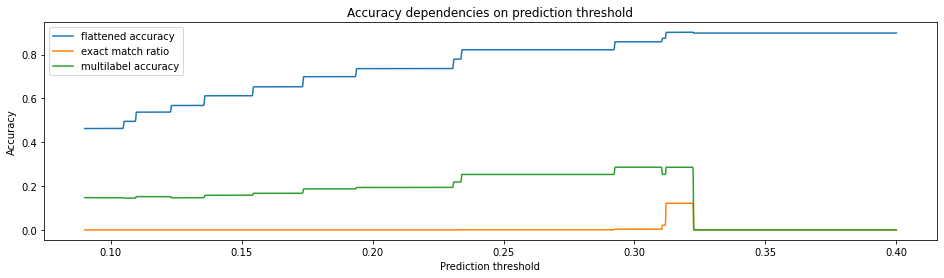

In [35]:
accuracy_dependecies_plot(acc_dep, title='Accuracy dependencies on prediction threshold',
                          save_file='ml_class_text2/accuracy_depencies.png')

In [36]:
print(f'Max flattened binary accuracy {np.round(acc_dep["flat. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["flat. acc."].argmax()], 4)} prediction threshold.')
print(f'Max exact match ratio {np.round(acc_dep["em. ratio"].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["em. ratio"].argmax()], 4)} prediction threshold.')
print(f'Max multilabel accuracy {np.round(acc_dep["ml. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["ml. acc."].argmax()], 4)} prediction threshold.')

Max flattened binary accuracy 0.9016 for 0.3224 prediction threshold.
Max exact match ratio 0.1214 for 0.3121 prediction threshold.
Max multilabel accuracy 0.2864 for 0.3121 prediction threshold.
